Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


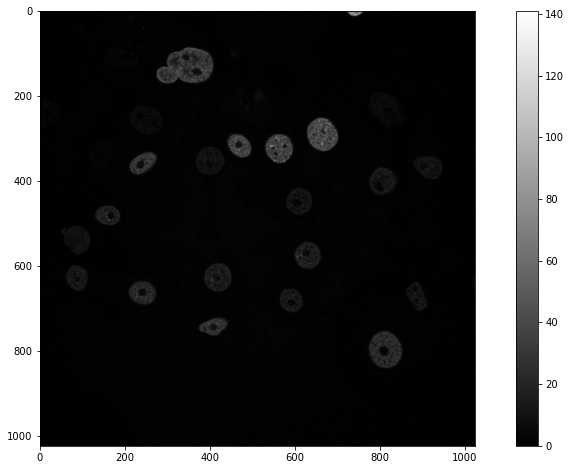

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


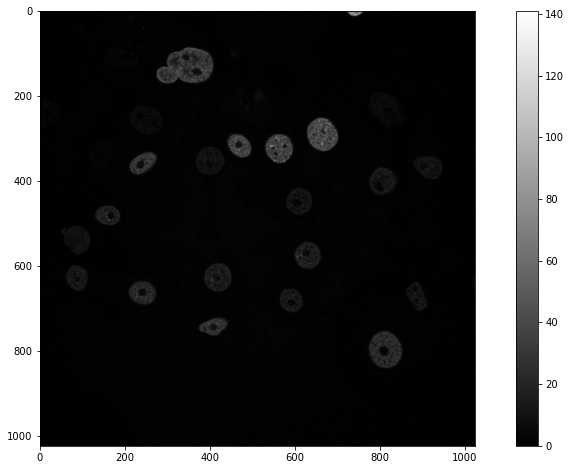

In [2]:
%pylab
%matplotlib inline
import skimage.io as sk

img = sk.imread("Data/N2DH-GOWT1/img/t01.tif") #Versuch Bild zu laden

def show_image(img, x, y): # Funktion um Bilder schneller schön anzuzeigen
    figure(figsize=(x,y))
    imshow(img, "gray")
    colorbar()

show_image(img, 15, 8)

In [7]:
def standarddeviation(img, size): # Größe der Filtermaske, Seitenlänge, Standardabweichung
    result = numpy.zeros(img.shape) # Resultat-Bild gleich groß wie Eingangs-Bild
    n = (size - 1) // 2
    for p in ndindex(img.shape): # gibt für jedes Pizel ein Tupel mit (Reihe, Spalte)
        neighborhood_sum = 0
        mean = 0
        deviation = 0
        if p[0]-n >= 0 and p[1]-n >= 0 and p[0]+n <= img.shape[0] -1 and p[1]+n <= img.shape[1] -1: # Keine Randpixel
            for q in ndindex(size, size):
                i = p[0]-n + q[0]
                j = p[1]-n + q[1]
                neighborhood_sum += img[i,j]
            mean = neighborhood_sum/(size**2) # Im 3x3 Raster werden die Werte addiert und der Mittelwert gebildet
            for q in ndindex(size, size):
                i = p[0]-n + q[0]
                j = p[1]-n + q[1]
                deviation += (img[i,j] - mean)**2 # Die Abweichung der Werte zum Mittelwert wird berechnet und aufsummiert

            result[p] = sqrt(1/(size**2) * deviation) # Letzter Schritt zur Berechnung der Standardabweichung
    return result
sd_test = standarddeviation(img,3)

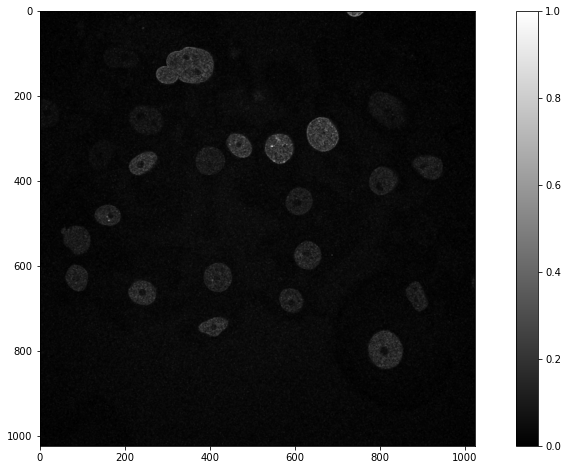

In [9]:
fl = sd_test.flatten()
max(fl) # maximale Standardabweichung

sd_n = sd_test.copy()/max(fl) # Bild auf sd genormt

show_image(sd_n, 15, 8)



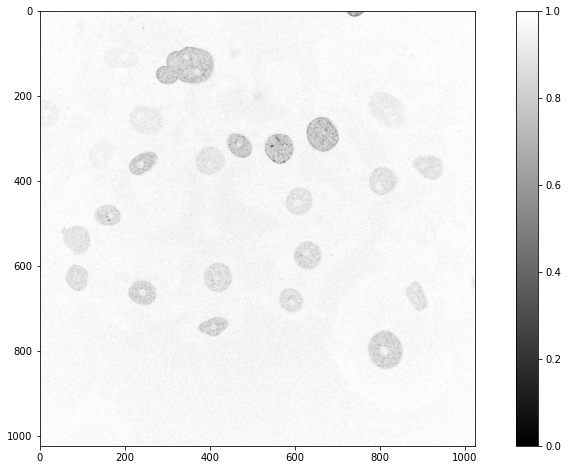

In [10]:
similarity = 1-sd_n # Similarity berechnen
# Grenzwert noch nicht bestimmt!
show_image(similarity, 15, 8)

<ipython-input-22-103d8fd75dbc>:10: RuntimeWarning: invalid value encountered in ubyte_scalars
  neighborhood_distance.append((img[p]-img[i,j])/img[p]) # die Relative Euclidische Distanz wird für jeden Nachbar in die Liste gespeichert
<ipython-input-22-103d8fd75dbc>:10: RuntimeWarning: overflow encountered in ubyte_scalars
  neighborhood_distance.append((img[p]-img[i,j])/img[p]) # die Relative Euclidische Distanz wird für jeden Nachbar in die Liste gespeichert
<ipython-input-22-103d8fd75dbc>:10: RuntimeWarning: divide by zero encountered in ubyte_scalars
  neighborhood_distance.append((img[p]-img[i,j])/img[p]) # die Relative Euclidische Distanz wird für jeden Nachbar in die Liste gespeichert


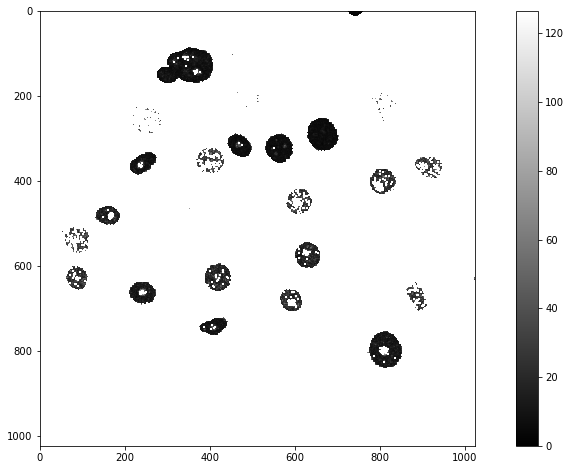

In [22]:
def euclidean_relative(img, size): # Größe der Filtermaske, Seitenlänge, Relative Euclidische Distanz
    result = numpy.zeros(img.shape) # Resultat-Bild gleich groß wie Eingangs-Bild
    n = (size - 1) // 2
    for p in ndindex(img.shape): # gibt für jedes Pizel ein Tupel mit (Reihe, Spalte)
        neighborhood_distance = [] # Distanzen der Nachbaren werden als Liste gespeichert
        if p[0]-n >= 0 and p[1]-n >= 0 and p[0]+n <= img.shape[0] -1 and p[1]+n <= img.shape[1] -1: # Keine Randpixel
            for q in ndindex(size, size):
                i = p[0]-n + q[0]
                j = p[1]-n + q[1]
                neighborhood_distance.append((img[p]-img[i,j])/img[p]) # die Relative Euclidische Distanz wird für jeden Nachbar in die Liste gespeichert

            result[p] = max(neighborhood_distance) # die maximale Distanz wird ausgewählt
    return result

eurel_test = euclidean_relative(img, 3)
show_image(eurel_test, 15, 8)

In [ ]:
def euclidean_n(img, size): # Größe der Filtermaske, Seitenlänge, Euclidische Distanz
    result = numpy.zeros(img.shape) # Resultat-Bild gleich groß wie Eingangs-Bild
    n = (size - 1) // 2
    for p in ndindex(img.shape): # gibt für jedes Pizel ein Tupel mit (Reihe, Spalte)
        neighborhood_distance = []
        if p[0]-n >= 0 and p[1]-n >= 0 and p[0]+n <= img.shape[0] -1 and p[1]+n <= img.shape[1] -1: # Keine Randpixel
            for q in ndindex(size, size):
                i = p[0]-n + q[0]
                j = p[1]-n + q[1]
                neighborhood_distance.append(sqrt((img[p]-img[i,j])**2)) # Euclidische Distanz wird gespeichert
                #kann man hier nicht das sqrt und **2 rausnehmen?
            result[p] = max(neighborhood_distance)
    return result

eu_test = euclidean_n(img, 3)
show_image(eu_test, 15, 8)

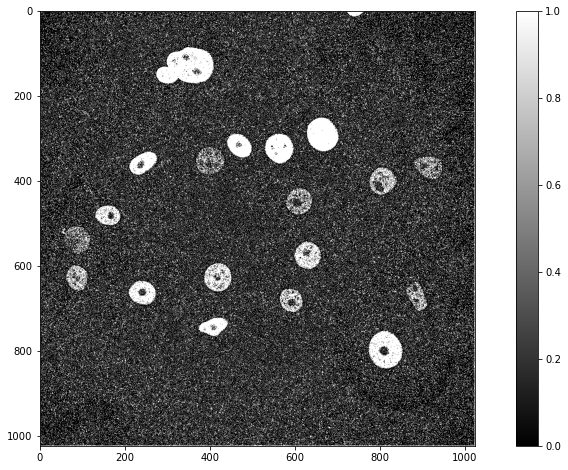

In [21]:
T1 = 0.4 # Wert anhand Bild geschätzt
T2 = 30 # Wert anhand Bild geschätzt

def seeds_test(img):
    result = numpy.zeros(img.shape)
    for p in ndindex(img.shape): # Ränder haben den Wert 0
        if similarity[p] > T1 and eurel_test[p] < T2: # Theorie aus Paper 1
            result[p] = 1 # Pixel die als Seed in Frage kommen sind weiß, der Rest ist schwarz
    return result

seed_t = seeds_test(img)
show_image(seed_t, 15, 8)

In [6]:
def seeds(img, T1, T2): # Seed Funktion, so dass man später gut auf die anderen Funktionen zugreifen kann
    result = numpy.zeros(img.shape)
    sd_seeds = standarddeviation(img,3) # Standardabweichung
    sd_flat = sd_seeds.flatten() # Standardabweichung als array
    similarity_seeds = 1 - sd_seeds/max(sd_flat) # Similarity berechnet
    eurel_seeds = euclidean_relative(img, 3) # Euclidische Distanz
    for p in ndindex(img.shape): # Ränder haben den Wert 0
        if similarity_seeds[p] > T1 and eurel_seeds[p] < T2:
            result[p] = 1 # Wenn beide Bedingungen zutreffen, kommt Pixel als Seed infrage
    return result

seed_final = seeds(img, 0.4, 20)
show_image(seed_final, 15, 8)

NameError: name 'standarddeviation' is not defined

test
